In [1]:
!nvidia-smi

Wed Oct 24 19:21:38 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P0    49W / 275W |      0MiB / 11170MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 106...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   30C    P0    27W / 156W |      0MiB /  6072MiB |      2%      Default |
+-------------------------------+----------------------+----------------------+
        

In [1]:
import torch
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from networks import *

In [3]:
from data_loader.data_loaders import MnistDataLoader

In [4]:
code_size = 100 
code_gen = CodeGenerator(code_size, noise_size=code_size)
encoder = Encoder(code_size)
decoder = Decoder(code_size)
disc_code = CodeDiscriminator(code_size)
disc_img = ImageDiscriminator()

In [5]:
n_gpu_use = 1
device = torch.device('cuda:0' if n_gpu_use > 0 else 'cpu')

encoder = encoder.to(device)
decoder = decoder.to(device)
code_gen = code_gen.to(device)
disc_code = disc_code.to(device)
disc_img = disc_img.to(device)

optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=10e-4)
optimizer_dec = torch.optim.Adam(decoder.parameters(), lr=10e-4)
optimizer_disc_img = torch.optim.Adam(disc_img.parameters(), lr=10e-4)
optimizer_disc_code = torch.optim.Adam(disc_code.parameters(), lr=10e-4)
optimizer_code_gen = torch.optim.Adam(code_gen.parameters(), lr=10e-4)

In [6]:
batch_size = 128
data_loader = MnistDataLoader('mnist_data', batch_size=batch_size, shuffle=True, validation_split=0.2, num_workers=1)

In [7]:
import torch, torchvision

traindataset = torchvision.datasets.MNIST('mnist_data', transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                  torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
data_loader = torch.utils.data.dataloader.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=8)

In [8]:
import time

In [16]:
decoder = torch.load('aae_models/decoder')
code_gen = torch.load('aae_models/code_gen')

In [9]:
# optimizer_G = torch.optim.Adam([encoder.parameters(), decoder.parameters()])
# optimizer_D = torch.optim.Adam([disc_code.parameters(), disc_img.parameters()])

dec_weight = 2
eps = 1e-10

cross_entropy_loss = torch.nn.BCELoss()
mse_loss = torch.nn.MSELoss() 

def train_epoch(i):
    enc_total_loss = 0
    dec_total_loss = 0
    disc_code_total_loss = 0
    disc_img_total_loss = 0
    
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        cur_batch_size = data.shape[0]
        # AAE phase
        z = torch.randn((cur_batch_size, code_size)).to(device)
        code_gen.eval() #train(False)
        disc_img.eval() #train(False)
        encoder.train()
        disc_code.train()
        decoder.train()
        
#         optimizer_enc.zero_grad()
#         optimizer_disc_code.zero_grad()
#         optimizer_dec.zero_grad()

        z_code = code_gen(z)
        data_repr = encoder(data)
        data_rec = decoder(data_repr)

        loss_rec = mse_loss(data_rec, data.detach()) #mse_loss(disc_img(data_rec)[0], disc_img(data)[0].detach()) #.fmap
        disc_code_pred_fake = disc_code(data_repr).reshape(cur_batch_size)
        gen_adv_loss = -torch.log(disc_code_pred_fake+eps).mean()
        enc_loss = loss_rec + gen_adv_loss

        optimizer_enc.zero_grad()        
        enc_loss.backward(retain_graph=True)
        optimizer_enc.step()
        enc_total_loss += enc_loss.data.cpu().numpy().item()

        if (batch_idx+1)%5==0:
            disc_code_pred_fake = disc_code(data_repr).reshape(cur_batch_size)
            disc_code_pred_real = disc_code(z_code).reshape(cur_batch_size)
            disc_code_gan_loss = -2*(torch.log(disc_code_pred_real+eps) + torch.log(1-disc_code_pred_fake+eps)).mean()
            optimizer_disc_code.zero_grad()
            disc_code_gan_loss.backward(retain_graph=True)
            optimizer_disc_code.step()   
            disc_code_total_loss += disc_code_gan_loss.data.cpu().numpy().item()

        dec_loss = loss_rec
        optimizer_dec.zero_grad()
        dec_loss.backward(retain_graph=False)
        optimizer_dec.step()
        dec_total_loss += dec_loss.data.cpu().numpy().item()
        
        
        if i >= 0:
            # Prior improvement phase
            encoder.eval()
            disc_code.eval()
            code_gen.train()
            disc_img.train()
            decoder.train()        

            if batch_idx==0:
                z = torch.randn((cur_batch_size, code_size)).to(device)
                z_code = code_gen(z)
                x_sampled = decoder(z_code)
                data_repr = encoder(data)
                data_rec = decoder(data_repr)

                disc_img_pred_fake = disc_img(x_sampled)[0].reshape(cur_batch_size)
                disc_img_pred_real = disc_img(data)[0].reshape(cur_batch_size)
                disc_img_pred_fake_ae = disc_img(data_rec)[0].reshape(cur_batch_size)
                disc_img_gan_loss = -(torch.log(disc_img_pred_real+eps) + torch.log(1-disc_img_pred_fake+eps) + torch.log(1-disc_img_pred_fake_ae+eps)).mean()

                optimizer_disc_img.zero_grad()
                disc_img_gan_loss.backward(retain_graph=True)
                optimizer_disc_img.step()
                disc_img_total_loss += disc_img_gan_loss.data.cpu().numpy().item()
                
                z = torch.randn((cur_batch_size, code_size)).to(device)
                z_code = code_gen(z)
                x_sampled = decoder(z_code)
                disc_img_pred_fake = disc_img(x_sampled)[0].reshape(cur_batch_size)
                gen_adv_loss = -(torch.log(disc_img_pred_fake+eps)).mean()

                optimizer_code_gen.zero_grad()
                optimizer_dec.zero_grad()
                gen_adv_loss.backward(retain_graph=False)
                optimizer_dec.step()
                optimizer_code_gen.step()

        if batch_idx%10==0:
            z_code = code_gen(z)
            x_sampled = decoder(z_code)
            clear_output(wait=True)
            print("enc_total_loss:", enc_total_loss)
            print("dec_total_loss:", dec_total_loss)
            print("disc_code_total_loss:", disc_code_total_loss)
            print("disc_img_total_loss:", disc_img_total_loss)
            plt.imshow(((data_rec[1].data.cpu().numpy()+1)/2).reshape(28,28), cmap='gray')
            plt.show()
            plt.imshow(((x_sampled[1].data.cpu().numpy()+1)/2).reshape(28,28), cmap='gray')
            plt.show()

    clear_output(wait=True)
    plt.imshow(((data_rec[1].data.cpu().numpy()+1)/2).reshape(28,28), cmap='gray')
    plt.savefig('log_img/'+str(i)+'.png')
    plt.show()
    print("enc_total_loss:", enc_total_loss)
    print("dec_total_loss:", dec_total_loss)
    print("disc_code_total_loss:", disc_code_total_loss)
    print("disc_img_total_loss:", disc_img_total_loss)
    print()

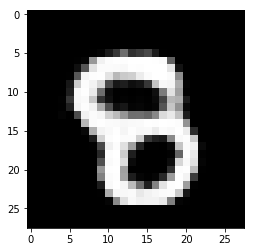

enc_total_loss: 350.43748235702515
dec_total_loss: 25.76398128271103
disc_code_total_loss: 259.7655007839203
disc_img_total_loss: 1.6670998334884644

99


In [10]:
for i in range(100):
    train_epoch(i)
    torch.save(encoder, "encoder")
    torch.save(decoder, "decoder")
    torch.save(disc_code, "disc_code")
    torch.save(disc_img, "disc_img")
    torch.save(code_gen, "code_gen")
    print(i)

In [ ]:
def get_model_norm_grad(model):
    cur_norm = 0
    for par in model.parameters():
        cur_norm = par.grad.norm()
    print(model.__class__.__name__, cur_norm)


In [10]:
for x, y in data_loader:
    x_enc = encoder(x.cuda())
    break

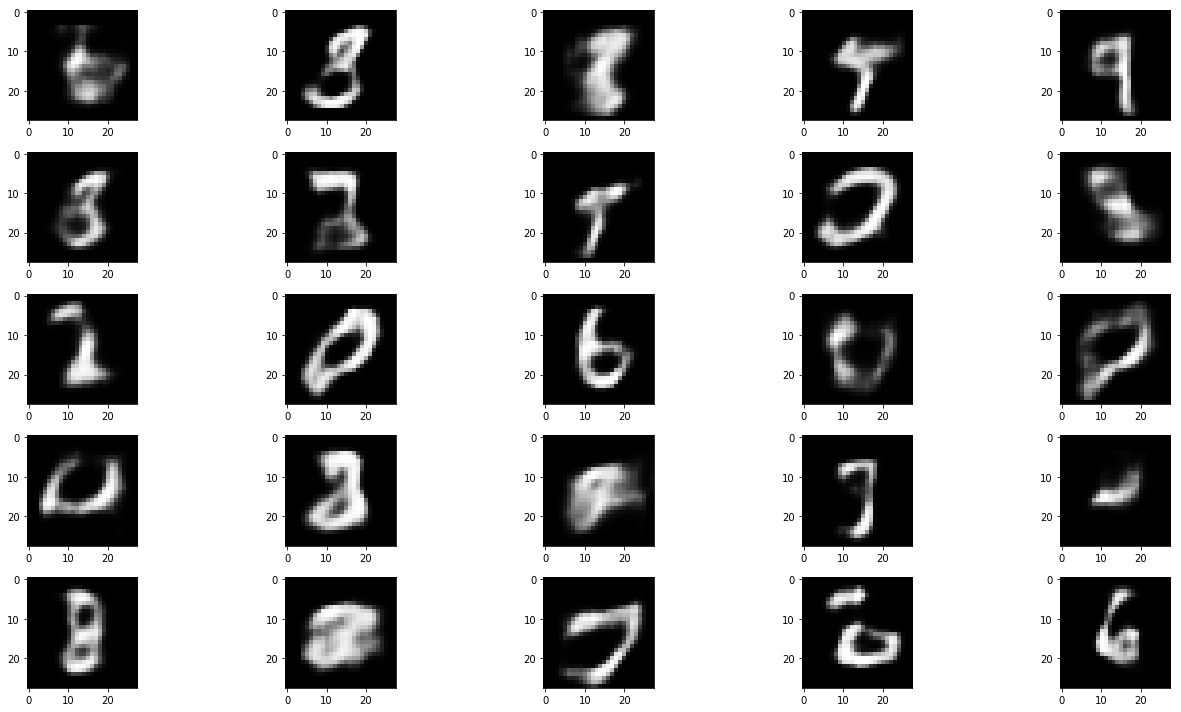

In [17]:
n_rows = 5
n_columns = 5
f, axes = plt.subplots(n_rows, n_columns, figsize=(19, 10))
z = (torch.randn((n_rows*n_columns, code_size))).to(device)
z_code = code_gen(z)
data_samples = decoder(z_code)

for i in range(n_rows):
    for j in range(n_columns):
        axes[i][j].imshow(((data_samples[n_rows*i+j].data.cpu().numpy()+1)/2).reshape(28,28), cmap='gray')
f.tight_layout()

In [18]:
x_rec = decoder(x_enc[0].unsqueeze(0))

In [11]:
for x, y in data_loader:
    x_rec = decoder(encoder(x.cuda()))
    break

In [22]:
x[0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

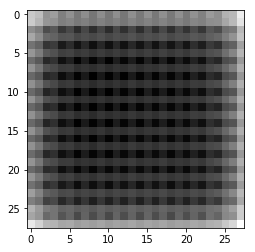

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(((x_rec[0].data.cpu().numpy()+1)/2).reshape(28, 28), cmap='gray')

In [16]:
x_rec[1].min()

tensor(-1., device='cuda:0')

In [65]:
x[1].data.cpu().numpy().reshape(28,28)

array([[-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.4242

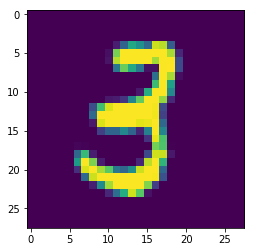

In [64]:
plt.imshow(x[1].data.cpu().numpy().reshape(28,28))

In [7]:


n_gpu_use = 1
device = torch.device('cuda:0' if n_gpu_use > 0 else 'cpu')

encoder = encoder.to(device)
decoder = decoder.to(device)
code_gen = code_gen.to(device)
disc_code = disc_code.to(device)
disc_img = disc_img.to(device)

dec_weight = 2

cross_entropy_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss() 


In [10]:
for batch_idx, (data, target) in enumerate(data_loader):
    data, target = data.to(device), target.to(device)

    # AAE phase
    z = torch.randn((batch_size, 8)).to(device)
    code_gen.train(False)
    disc_img.train(False)
    encoder.train()
    disc_code.train()
    decoder.train()

    z_code = code_gen(z)
    data_repr = encoder(data)
    data_rec = decoder(data_repr)
    loss_rec = mse_loss(disc_img(data_rec)[0], disc_img(data)[0].detach()) #.fmap
    disc_code_input = torch.cat((z_code, data_repr))
    disc_code_pred = disc_code(disc_code_input)
    disc_code_target = torch.cat((torch.ones(batch_size), torch.zeros(batch_size))).long().to(device)
    break 
    disc_code_gan_loss = cross_entropy_loss(disc_code_pred, disc_code_target)


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [12]:
cross_entropy_loss(disc_code_pred, disc_code_target)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorCopy.c:70

In [11]:
disc_img(data_rec)[0]

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]],


        [[[ 0.4957]]]], device='cuda:0')

In [13]:
cross_entropy_loss(disc_code_pred, disc_code_target.long())

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorCopy.c:70

In [14]:
loss_rec.backward()